<a href="https://colab.research.google.com/github/AliAlsaedi25/demo/blob/main/HW3Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163334 sha256=28f945b85c7c13bbc058c5854492c5122fdff29860439f30a9a8caf4352b32f3
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Prediction
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise import AlgoBase, Prediction, accuracy
from surprise.prediction_algorithms.knns import PredictionImpossible
import os

In [5]:
ratings = pd.read_csv('/content/drive/MyDrive/hw2_data/ratings.csv')

In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119
...,...,...,...,...
33832157,330975,8340,2.0,1091583256
33832158,330975,8493,2.5,1091585709
33832159,330975,8622,4.0,1091581777
33832160,330975,8665,3.0,1091581765


In [7]:
ratings = ratings.drop(columns='timestamp', axis = 1)

In [8]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
...,...,...,...
33832157,330975,8340,2.0
33832158,330975,8493,2.5
33832159,330975,8622,4.0
33832160,330975,8665,3.0


In [9]:
genome_scores = pd.read_csv('/content/drive/MyDrive/hw2_data/genome-scores.csv')

In [10]:
genome_scores

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300
...,...,...,...
18472123,288167,1124,0.09875
18472124,288167,1125,0.02950
18472125,288167,1126,0.02275
18472126,288167,1127,0.11225


In [11]:
th_index = len(ratings) // 25

# Keep the first half of the DataFrame
n_ratings = ratings.iloc[:th_index]

In [12]:
len(n_ratings)

1353286

In [13]:
class MF(AlgoBase):
    def __init__(self,learning_rate,num_epochs,num_factors):
      AlgoBase.__init__(self)

      self.learning_rate = learning_rate
      self.num_epochs = num_epochs
      self.num_factors = num_factors

    def fit(self,train):

      AlgoBase.fit(self,train)
      self.trainset = train

      #intialize user and item matrics with random values
      self.user_matrix = np.random.rand(train.n_users, self.num_factors)
      self.item_matrix = np.random.rand(train.n_items, self.num_factors)

      for _ in range(self.num_epochs):
        for u, i, r in train.all_ratings():
          error = r - np.dot(self.user_matrix[u], self.item_matrix[i])

          #update user and item matrics using gradient decent
          self.user_matrix[u] += self.learning_rate * (error * self.item_matrix[i])
          self.item_matrix[i] += self.learning_rate * (error * self.user_matrix[u])

      return self

    def estimate(self,u,i):

      if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
        raise PredictionImpossible('User and/or item is unknown.')

      est = np.dot(self.user_matrix[u], self.item_matrix[i])

      return est

In [15]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5))
dataset = Dataset.load_from_df(n_ratings, reader=reader)

trainset, testset = train_test_split(dataset, test_size=0.2)

In [16]:
# Define the parameter grid for the hyperparameters
param_grid = {
    'lr_all': [0.001, 0.01, 0.1],
    'n_factors': [5, 10, 15],
    'n_epochs': [10, 20, 30],
}


In [17]:
# Initialize GridSearchCV with the SVD algorithm and parameter grid
grid_search = GridSearchCV(SVD, param_grid=param_grid, measures=['rmse', 'mae'], cv=3)

grid_search.fit(dataset)


In [18]:
best_params = grid_search.best_params['rmse']
best_rmse = grid_search.best_score['rmse']
best_mae = grid_search.best_score['mae']

print(f'Best Parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best MAE: {best_mae}')

Best Parameters: {'lr_all': 0.01, 'n_factors': 5, 'n_epochs': 30}
Best RMSE: 0.8339449045290298
Best MAE: 0.6299552314931236


In [19]:
num_factors_range = [5, 10, 15, 20, 25, 30]

# Initialize lists to store num_factors and RMSE values
num_factors_values = []
rmse_values = []

learning_rate = 0.01  # You can use the optimal learning rate obtained from previous grid search
num_epochs = 30

In [20]:
for num_factors in num_factors_range:
    # Create an instance of the MF algorithm with the current num_factors
    mf = MF(learning_rate=learning_rate, num_epochs=num_epochs, num_factors=num_factors)

    mf.fit(trainset)
    predictions = mf.test(testset)

    rmse = accuracy.rmse(predictions)

    num_factors_values.append(num_factors)
    rmse_values.append(rmse)


RMSE: 0.8612
RMSE: 0.8666
RMSE: 0.8822
RMSE: 0.8985
RMSE: 0.9140
RMSE: 0.9295


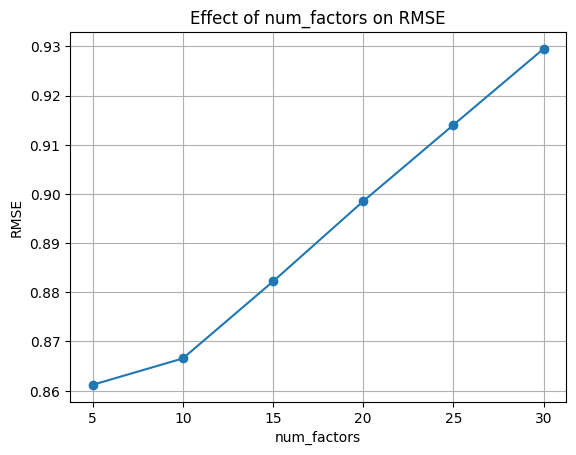

In [22]:
# Create a plot
plt.plot(num_factors_values, rmse_values, marker='o', linestyle='-')
plt.title('Effect of num_factors on RMSE')
plt.xlabel('num_factors')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()